val accuracy tensor(0.3115)
iter:500 training loss: 1.9227938652038574, val loss: 1.6146470308303833
val accuracy tensor(0.2979)
iter:1000 training loss: 1.9788912534713745, val loss: 1.3547338247299194
val accuracy tensor(0.3418)
iter:1500 training loss: 1.2470223903656006, val loss: 1.3967978954315186
val accuracy tensor(0.4609)
iter:2000 training loss: 1.0857356786727905, val loss: 1.5440709590911865
val accuracy tensor(0.4570)
iter:2500 training loss: 1.233010172843933, val loss: 1.0762265920639038
val accuracy tensor(0.4922)
iter:3000 training loss: 0.8684751391410828, val loss: 0.9141905307769775
val accuracy tensor(0.5166)
iter:3500 training loss: 1.0028223991394043, val loss: 1.313122034072876
val accuracy tensor(0.5117)
iter:4000 training loss: 0.8804166316986084, val loss: 0.8565753698348999
val accuracy tensor(0.5439)
iter:4500 training loss: 1.1405125856399536, val loss: 1.2317028045654297
val accuracy tensor(0.4883)
iter:5000 training loss: 1.3017582893371582, val loss: 1.

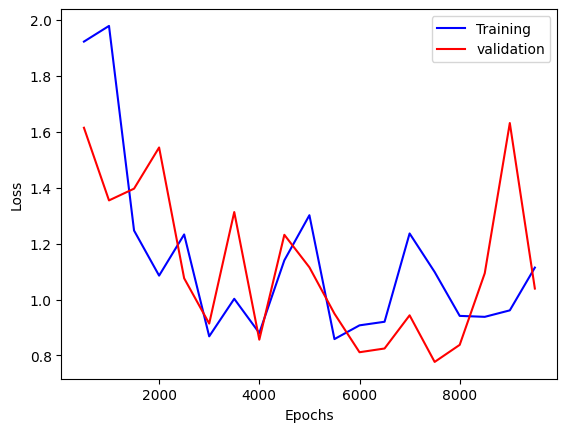

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px
from dataclasses import dataclass

torch.manual_seed(10)



input_size = 5
learning_rate = 0.001
max_iters = 10000
dataset_size = 1024*32
batch_size = 8


iters = []
loss_value = []
val_loss_value = []


def sample_data(split = 'train', batch_size = batch_size):
    if split != 'train':
        curr_data = validation_dataset
    else:
        curr_data = training_dataset
    curr_data = curr_data[torch.randperm(curr_data.shape[0])][:batch_size]
    a, b = curr_data.shape
    
    sparsity_vector = torch.rand(a, b)
    sparsity_mat = torch.bernoulli(torch.full((a, b), 1.0) * sparsity_vector)
    
    X = curr_data * sparsity_mat
    return X



DEVICE = torch.device('cpu')

@dataclass
class Config:
    input_size : int
    hidden_size : int = 2
    layers : int = 1

class Two_Two(nn.Module):
    def __init__(self, hidden_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(hidden_size,hidden_size), nn.ReLU(), nn.Linear(hidden_size,hidden_size) )
    
    def forward(self, idx):
        return self.layers(idx)

class Model(nn.Module):
    def __init__(self, config : Config) -> None:
        super().__init__()
        self.config = config
        self.layers = nn.Sequential(
                        nn.Linear(config.input_size, config.hidden_size),
                        *[Two_Two(config.hidden_size) for i in range(config.layers)],
                        nn.Linear(config.hidden_size, config.input_size + 1),
                    )

    
    def forward(self, idx : torch.Tensor):
        count = self.layers(idx) 
        active = (idx>0).sum(-1)

        loss = nn.CrossEntropyLoss()
        
        return count, loss(count, active)


        

training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = Model(Config(input_size= input_size))

def get_accuracy():
    a= sample_data(split = 'val', batch_size= 1024)
    n = (model(a)[0].argmax(-1) == (a>0).sum(-1))
    print("val accuracy",n.sum()/a.shape[0])
optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
start_time = time.time()
step_value = max_iters/20
for i in range(1, max_iters):
    X =  sample_data()
    count, loss = model(X)
   
    if i%step_value ==0 :
        model.eval()
        with torch.no_grad():
            get_accuracy()
            X_V = sample_data(split = 'val')
            _, val_loss= model(X_V)
            iters.append(i)
            loss_value.append(loss.item())
            val_loss_value.append(val_loss.item())
            print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
        model.train()

    optimizer.zero_grad(set_to_none=True)
    #loss+= get_l1_penalty()
    loss.backward()
    optimizer.step()


end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()

In [99]:
a= sample_data()
print(a[:5])
print(model(a[:5])[0].argmax(-1), (a[:5]>0).sum(-1))

tensor([[0.0000, 0.5337, 0.0000, 0.7359, 0.4579],
        [0.0525, 0.0000, 0.0000, 0.4474, 0.9541],
        [0.0000, 0.0000, 0.9588, 0.0000, 0.8835],
        [0.6518, 0.0000, 0.0000, 0.3417, 0.9089],
        [0.0000, 0.9097, 0.0000, 0.0173, 0.8493]])
tensor([3, 3, 3, 3, 3]) tensor([3, 3, 2, 3, 3])


tensor([[0.0000, 0.4829, 0.3125, 0.6150, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.6178, 0.0000],
        [0.0000, 0.4440, 0.0000, 0.0000, 0.0000],
        [0.9849, 0.2924, 0.0000, 0.0000, 0.0000]])

tensor(0.5430)


In [108]:
get_accuracy()

val accuracy tensor(0.5557)


In [ ]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()


In [ ]:
target

tensor([2, 4, 4])

In [ ]:
input

tensor([[-1.1628,  0.8057,  1.4753,  0.1253,  0.4515],
        [ 0.4052, -0.8902, -0.0954,  0.1275,  0.6059],
        [ 0.5909,  0.4728, -0.7371,  0.5379, -0.0618]], requires_grad=True)

In [ ]:
output

tensor(1.2930, grad_fn=<NllLossBackward0>)

In [ ]:
idx = torch.rand(100,10)
active = (idx>0).sum(-1)

loss = nn.CrossEntropyLoss(count, active)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
idx.shape, active.shape

(torch.Size([100, 10]), torch.Size([100]))

In [ ]:
active -1 

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9])

In [117]:
def chinchilla(n,d):
    n = n*pow(10,9) # Billion
    d = d*pow(10,9)
    return 1.69 + 406/(pow(n,0.34)) + 410/(pow(d, 0.28))


In [138]:
chinchilla(175*10*10, 300*10*5)

1.7866064656268597